# Basic usage of SLAT
In this vignette, we show how to use `SLAT` to align spatial datasets.

(You can run this demo in your laptop with >= 8GB memory in 50-100 scends, use GPU can be faster)

In [45]:
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [3]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

## Build datasets
Here, we sample 6000 cells(sample 1) and 5000 cells(sample 2) from two E15.5 mouse embryo dataset respectively.

In [4]:
adata_raw1 = sc.read('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S1_filter_labeled.h5ad')
adata_raw2 = sc.read('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S2_filter_labeled.h5ad')

In [5]:
adata1 = sc.pp.subsample(adata_raw1, n_obs=6000, copy=True)
adata2 = sc.pp.subsample(adata_raw2, n_obs=5000, copy=True)
del adata_raw1, adata_raw2

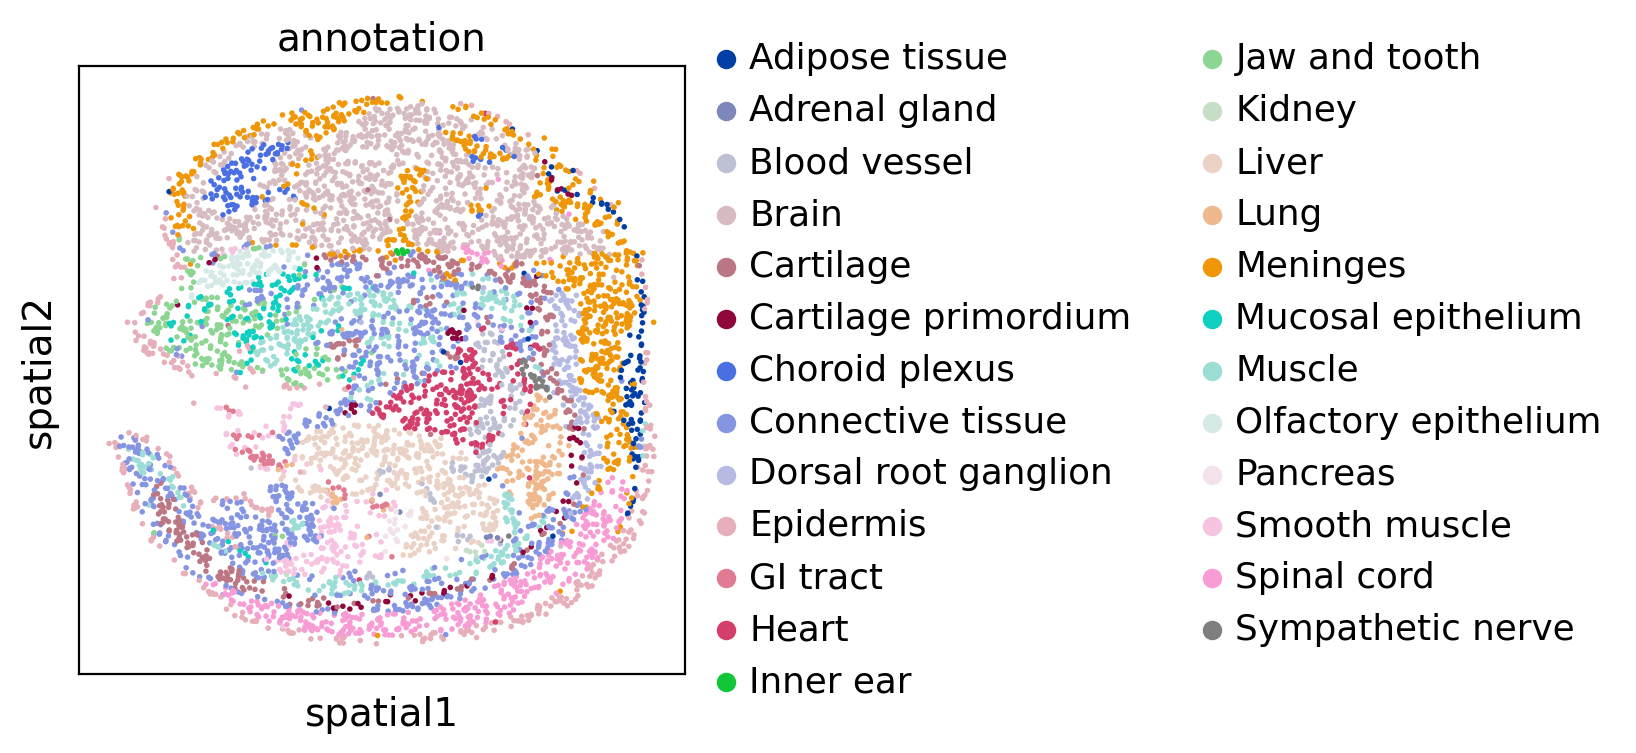

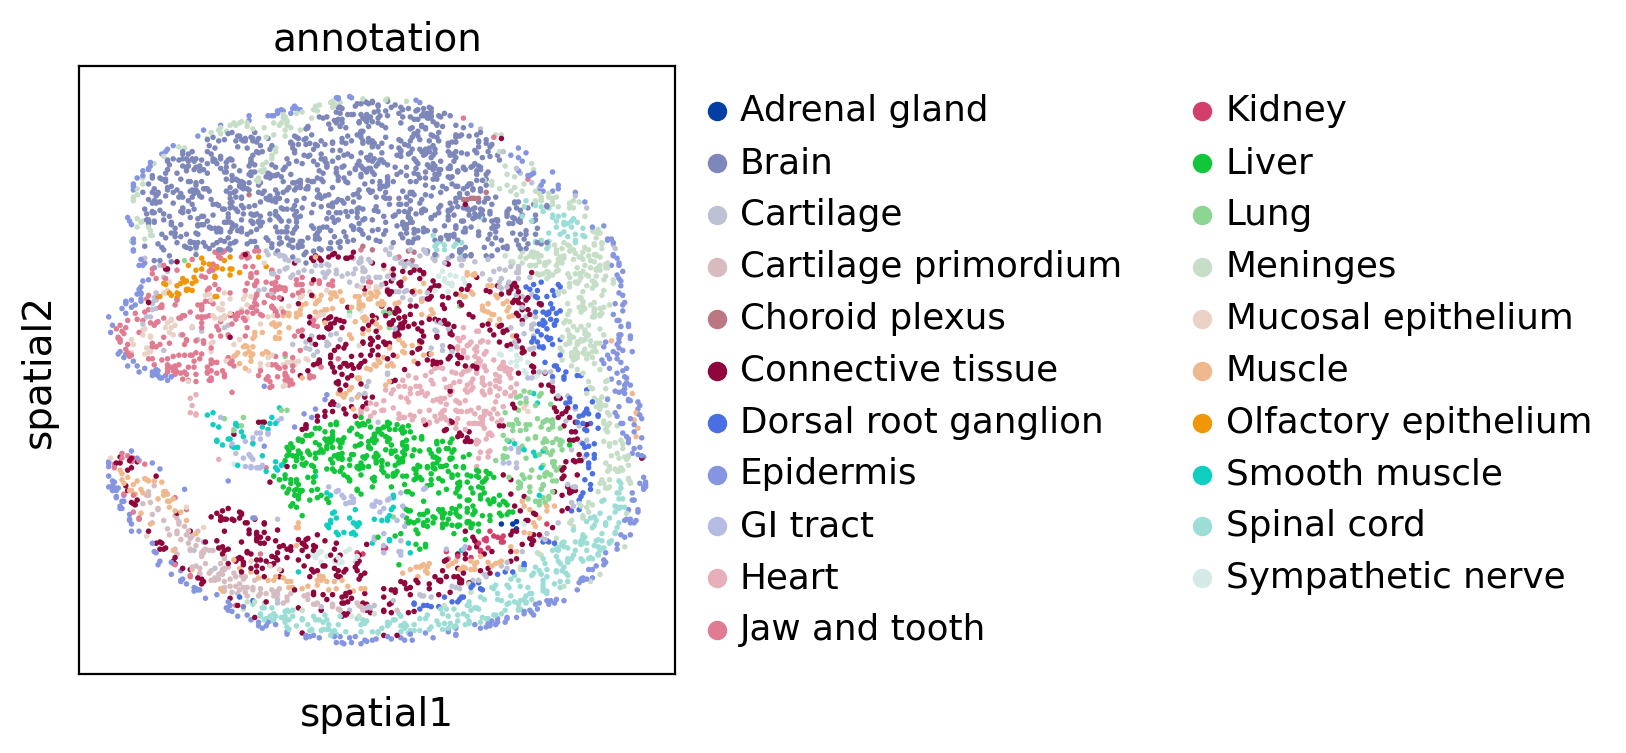

In [6]:
sc.pl.spatial(adata1, color="annotation", spot_size=10)
sc.pl.spatial(adata2, color="annotation", spot_size=10)

## Run SLAT
First, SLAT need build cell graphs based on cell-cell distance in spatial dataset

In [7]:
Cal_Spatial_Net(adata1, k_cutoff=50, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=50, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 300000 edges, 6000 cells.
50.0000 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 250000 edges, 5000 cells.
50.0000 neighbors per cell on average.


Then, SLAT extract cell gene expression features based on PCA algorithm, and extract cell position features based on graph we built on previous step
> NOTE: SLAT support `PCA`, `Harmony`, `HVG` and `GLUE` algorithm currently.

In [8]:
edges, features = load_anndatas([adata1, adata2], feature='Harmony')

Use Harmony feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Harmony is using GPU, which may lead to not duplicature result
Use GPU mode.
	Initialization is completed.
	Completed 1 / 30 iteration(s).
	Completed 2 / 30 iteration(s).
	Completed 3 / 30 iteration(s).
	Completed 4 / 30 iteration(s).
	Completed 5 / 30 iteration(s).
	Completed 6 / 30 iteration(s).
	Completed 7 / 30 iteration(s).
	Completed 8 / 30 iteration(s).
	Completed 9 / 30 iteration(s).
	Completed 10 / 30 iteration(s).
	Completed 11 / 30 iteration(s).
	Completed 12 / 30 iteration(s).
	Completed 13 / 30 iteration(s).
	Completed 14 / 30 iteration(s).
	Completed 15 / 30 iteration(s).
Reach convergence after 15 iteration(s).


Then we train SLAT model, it's very fast and finish in 10s.
> Warning: SLAT default hyperparameter can handle most situation. You should not change them unless you know details very well.

In [9]:
embd0, embd1, time = run_SLAT(features, edges)

Choose GPU:0 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Total Time 0.46


## Calculate metrics and visualization 
First, we check the confidence of the integrated results, > 0.90 means high confidence level.

If the confidence of most matches is less than 0.9. It suggests that the heterogeneity of the two slices is very high

In [27]:
best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)

Smoothing mapping, make sure object is in same direction


In [28]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype':adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype':adata2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match,start=0.5,number_of_interval=10)

0.500~0.550        23          0.460%
0.550~0.600        53          1.060%
0.600~0.650       138          2.760%
0.650~0.700       267          5.340%
0.700~0.750       519         10.380%
0.750~0.800       721         14.420%
0.800~0.850       845         16.900%
0.850~0.900       850         17.000%
0.900~0.950      1122         22.440%
0.950~1.000       459          9.180%


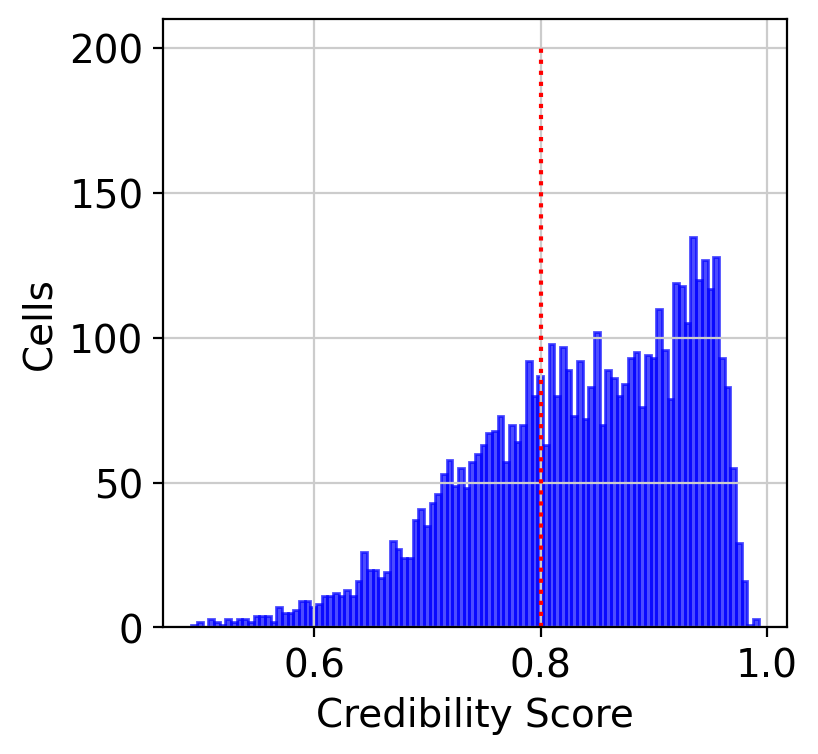

In [29]:
hist(best_match, cut=0.8)

Then we can visualize the cell to cell matching, color means cell type. By default, Blue line means correct match of cell type, red line is the opposite.

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scSLAT/viz/multi_dataset.py:238: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 25 cell types; dataset2: 21 cell types; 
                    Total :25 celltypes; Overlap: 21 cell types 
                    Not overlap :[['Blood vessel', 'Adipose tissue', 'Inner ear', 'Pancreas']]
Subsample 300 cell pairs from 5000


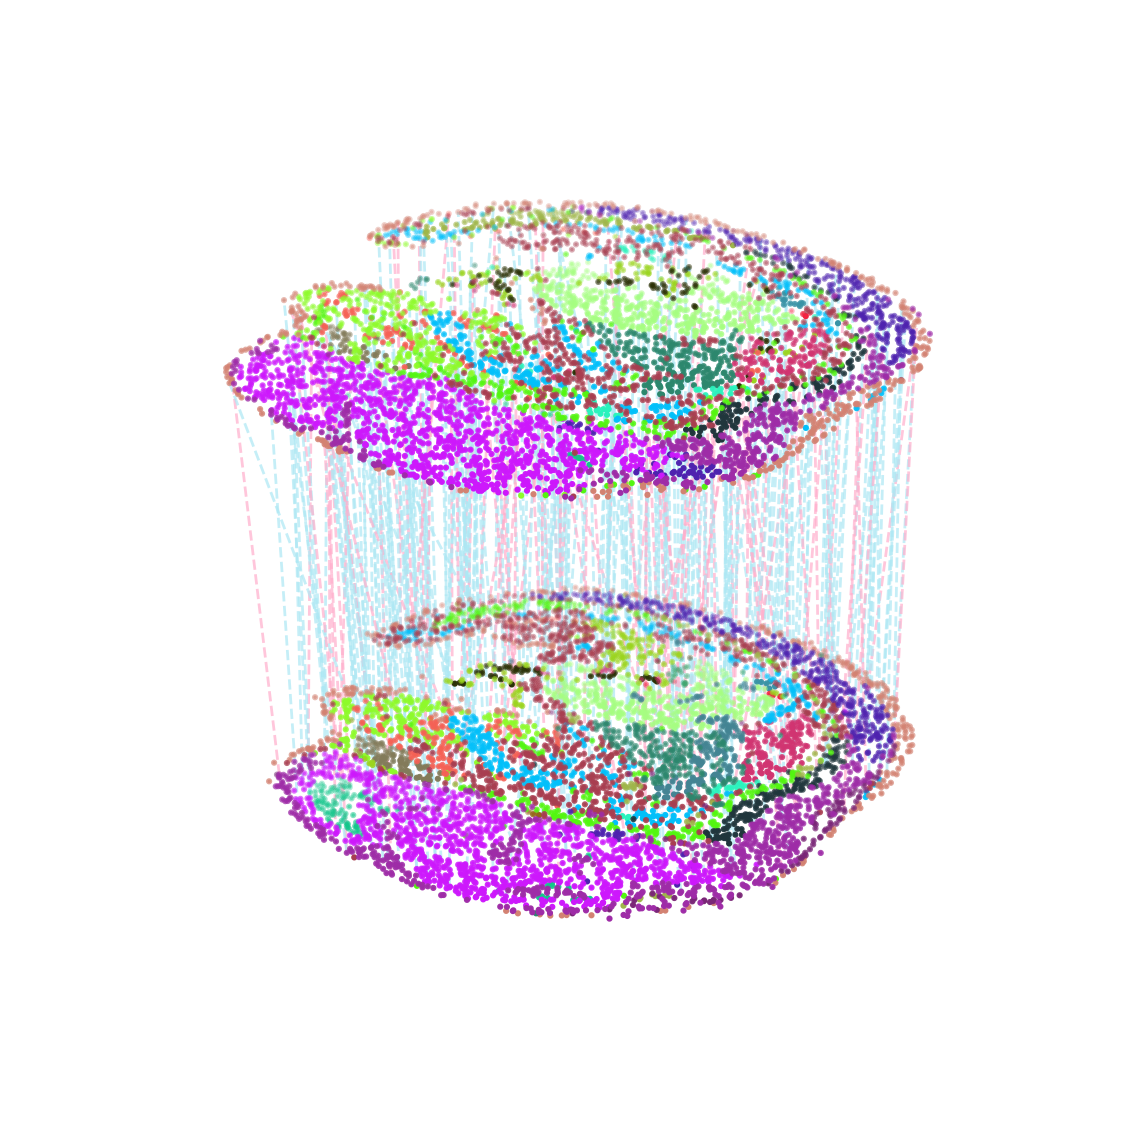

In [30]:
multi_align = match_3D_multi(adata1_df, adata2_df,matching,meta='celltype',
                            scale_coordinate=True,subsample_size=300)

multi_align.draw_3D(size= [7, 8],line_width =1,point_size=[1.5,1.5], hide_axis=True)

## Similarity score
**Similarity score** means the confident of `SLAT` alignment. Regions with low similarity scores may 1) have biological difference; 2)cause by technology.

In [32]:
adata2.obs['low_quality_index']= best_match 
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

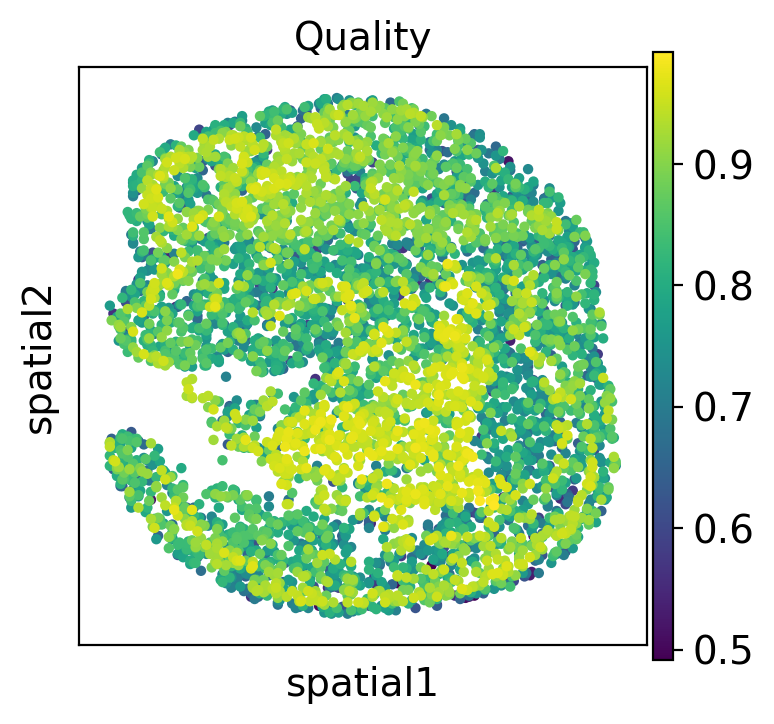

In [36]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=20, title='Quality')

## Cell type level analysis 
We can check the cell type level corresponding via Sankey diagram.

In [43]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [47]:
Sankey(matching_table,prefix=['E15.5_E1S1','E15.5_E1S2'])